In [1]:
import sys

sys.path.append("../")

In [2]:
import multiprocessing
import pickle
from concurrent.futures import ProcessPoolExecutor
from itertools import product

import numpy as np
from gymnasium.wrappers import FlattenObservation, RescaleAction, TimeLimit
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.env_util import unwrap_wrapper
from tqdm import tqdm

from src.environments import ea
from src.trial import load_trials
from src.wrappers import (
    NotVecNormalize,
    PlotEpisode,
    PolishedDonkeyCompatibility,
    RecordEpisode,
    RescaleObservation,
)

num_cpu_cores = multiprocessing.cpu_count()


In [3]:
trial = load_trials("../data/trials.yaml")[42]
trial


Trial(target_beam=array([-0.00187436,  0.00043831, -0.00154427,  0.00025756]), incoming_beam=array([1.23886362e+08, 9.81681282e-04, 2.94897309e-05, 9.69864952e-04,
       2.28377849e-05, 3.83874780e-04, 3.45051776e-05, 1.95113869e-04,
       3.65498709e-05, 1.26719879e-05, 6.46618719e-04]), misalignments=array([ 3.47587373e-04,  1.75187381e-04, -2.18960154e-05,  3.79141736e-04,
        1.10881388e-04,  2.37685896e-04, -1.89062717e-04,  1.06502764e-05]), initial_magnets=array([ 1.54016161e+01, -1.42649269e+01, -1.86484191e-03, -5.39294386e+00,
        5.16400579e-03]))

In [4]:
envs = [
    ea.TransverseTuning(
        backend="cheetah",
        action_mode="direct",
        target_beam_mode=trial.target_beam,
        magnet_init_mode=trial.initial_magnets,
        backend_args={
            "incoming_mode": trial.incoming_beam,
            "misalignment_mode": trial.misalignments,
        },
    )
    for _ in range(num_cpu_cores)
]
for env in envs:
    _, _ = env.reset()

In [5]:
action_component_linspaces = [
    np.linspace(-30, 30, 50, endpoint=True),
    np.linspace(-30, 30, 50, endpoint=True),
    np.linspace(
        envs[0].action_space.low[2], envs[0].action_space.high[2], 12, endpoint=True
    ),
    np.linspace(-30, 30, 50, endpoint=True),
    np.linspace(envs[0].action_space.low[4], envs[0].action_space.high[4], 12),
]
action_samples = list(product(*action_component_linspaces))

In [6]:
# Repeat 0 through 9 over the length of action_samples
action_envs = np.tile(np.arange(10), (len(action_samples) // 10) + 1)[
    : len(action_samples)
]

In [7]:
# Split actions into 10 sets of equal length
action_samples_split = np.array_split(action_samples, num_cpu_cores)
len(action_samples), len(action_samples_split[0])


def try_action(env, action):
    observation, _, _, _, info = env.step(action)
    return observation["beam"], info["beam_reward"]


def try_many_actions(env, actions):
    best_reward = 0
    best_beam = None
    best_action = None
    for action in tqdm(actions):
        beam, reward = try_action(env, action)
        if reward > best_reward:
            best_reward = reward
            best_beam = beam
            best_action = action

    return best_beam, best_reward, best_action

In [ ]:
with ProcessPoolExecutor(
    max_workers=num_cpu_cores, mp_context=multiprocessing.get_context("fork")
) as executor:
    results = executor.map(try_many_actions, envs, action_samples_split)

  0%|          | 6392/1800000 [00:03<16:51, 1773.67it/s]

  0%|          | 6664/1800000 [00:04<23:03, 1296.52it/s]

In [ ]:
list(results)


[(array([-0.00189996,  0.00040409, -0.00160281,  0.00032366], dtype=float32),
  0.9466537214838906,
  array([-2.51020408e+01,  1.89795918e+01, -5.61654525e-04, -1.77551020e+01,
         -3.93158168e-03])),
 (array([-0.00193407,  0.00041078, -0.00153166,  0.00028888], dtype=float32),
  0.9476345979113386,
  array([-2.02040816e+01,  2.14285714e+01, -5.61654525e-04, -1.65306122e+01,
         -5.61654525e-04])),
 (array([-0.00186805,  0.00049287, -0.00148399,  0.00026965], dtype=float32),
  0.9475743602249733,
  array([-1.65306122e+01,  1.53061224e+01, -5.61654525e-04, -1.28571429e+01,
         -5.05489073e-03])),
 (array([-0.0018132 ,  0.00043308, -0.00155983,  0.00025058], dtype=float32),
  0.9483831612642887,
  array([-1.04081633e+01,  4.28571429e+00, -5.61654525e-04,  6.73469388e+00,
         -6.17819978e-03])),
 (array([-0.0018785 ,  0.00041091, -0.0014759 ,  0.00025879], dtype=float32),
  0.9481477550951469,
  array([-4.28571429e+00,  1.65306122e+01, -2.80827263e-03, -6.73469388e+00,

In [18]:
results = [
    (
        np.array([-0.00189996, 0.00040409, -0.00160281, 0.00032366], dtype=np.float32),
        0.9466537214838906,
        np.array(
            [
                -2.51020408e01,
                1.89795918e01,
                -5.61654525e-04,
                -1.77551020e01,
                -3.93158168e-03,
            ]
        ),
    ),
    (
        np.array([-0.00193407, 0.00041078, -0.00153166, 0.00028888], dtype=np.float32),
        0.9476345979113386,
        np.array(
            [
                -2.02040816e01,
                2.14285714e01,
                -5.61654525e-04,
                -1.65306122e01,
                -5.61654525e-04,
            ]
        ),
    ),
    (
        np.array([-0.00186805, 0.00049287, -0.00148399, 0.00026965], dtype=np.float32),
        0.9475743602249733,
        np.array(
            [
                -1.65306122e01,
                1.53061224e01,
                -5.61654525e-04,
                -1.28571429e01,
                -5.05489073e-03,
            ]
        ),
    ),
    (  # MAX => idx = 3
        np.array([-0.0018132, 0.00043308, -0.00155983, 0.00025058], dtype=np.float32),
        0.9483831612642887,
        np.array(
            [
                -1.04081633e01,
                4.28571429e00,
                -5.61654525e-04,
                6.73469388e00,
                -6.17819978e-03,
            ]
        ),
    ),
    (
        np.array([-0.0018785, 0.00041091, -0.0014759, 0.00025879], dtype=np.float32),
        0.9481477550951469,
        np.array(
            [
                -4.28571429e00,
                1.65306122e01,
                -2.80827263e-03,
                -6.73469388e00,
                -1.68496358e-03,
            ]
        ),
    ),
    (
        np.array([-0.00188947, 0.00035025, -0.00154648, 0.00027791], dtype=np.float32),
        0.9476706026303751,
        np.array(
            [
                5.51020408e00,
                6.73469388e00,
                -1.68496358e-03,
                -2.63265306e01,
                -3.93158168e-03,
            ]
        ),
    ),
    (
        np.array([-0.00187399, 0.00042072, -0.00161187, 0.00027888], dtype=np.float32),
        0.9480513556070774,
        np.array(
            [
                7.95918367e00,
                3.06122449e00,
                -3.93158168e-03,
                -1.04081633e01,
                -3.93158168e-03,
            ]
        ),
    ),
    (
        np.array([-0.00177279, 0.00045668, -0.0015209, 0.00032326], dtype=np.float32),
        0.9461269659722276,
        np.array(
            [
                1.53061224e01,
                -1.40816327e01,
                -2.80827263e-03,
                1.28571429e01,
                -3.93158168e-03,
            ]
        ),
    ),
    (
        np.array([-0.00197546, 0.00045811, -0.00152735, 0.0003597], dtype=np.float32),
        0.9454985479011812,
        np.array(
            [
                2.02040816e01,
                -1.65306122e01,
                -2.80827263e-03,
                1.77551020e01,
                -3.93158168e-03,
            ]
        ),
    ),
    (
        np.array([-0.00194139, 0.0003357, -0.00157661, 0.00036503], dtype=np.float32),
        0.944231015461306,
        np.array(
            [
                2.75510204e01,
                -1.89795918e01,
                -2.80827263e-03,
                2.14285714e01,
                -3.93158168e-03,
            ]
        ),
    ),
]

In [ ]:
with open("../data/ea_grid_scan_results_p042.pkl", "wb") as f:
    pickle.dump(list(results), f)


Overwriting existing episode plots at /Users/jankaiser/Documents/DESY/ares-transverse-tuning/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.


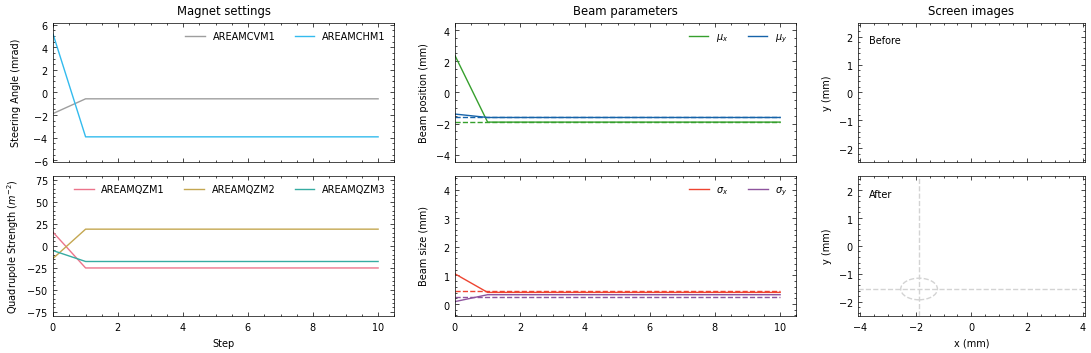

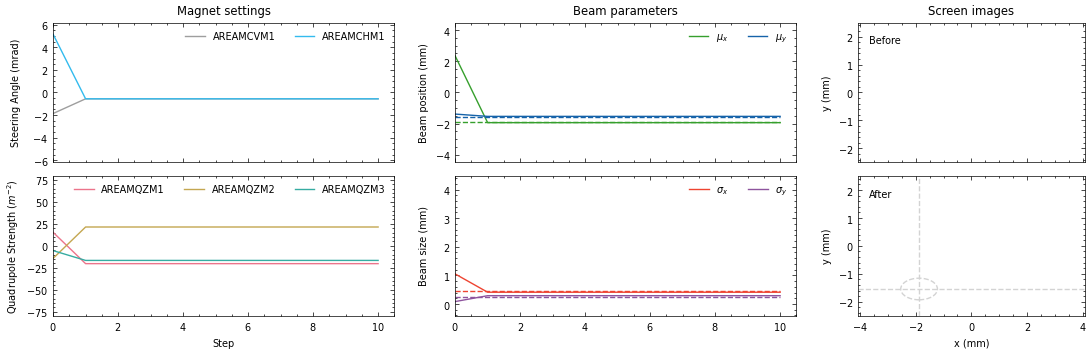

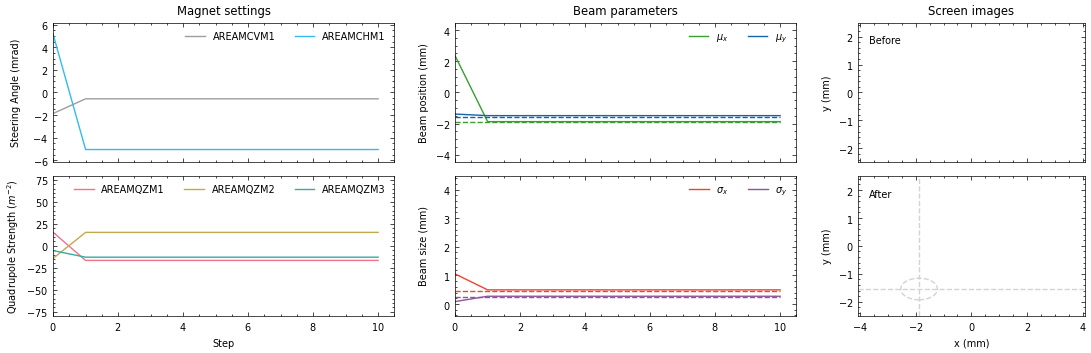

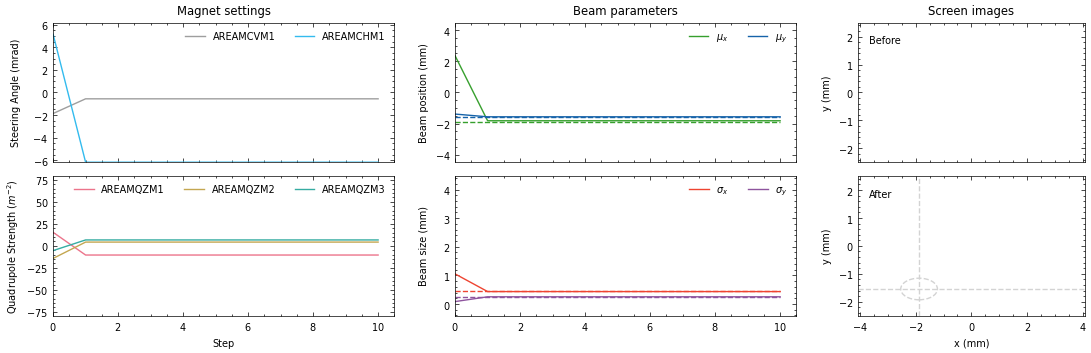

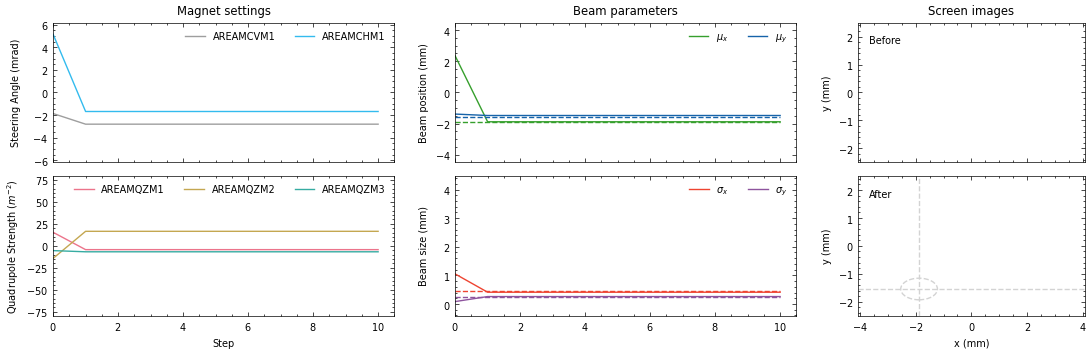

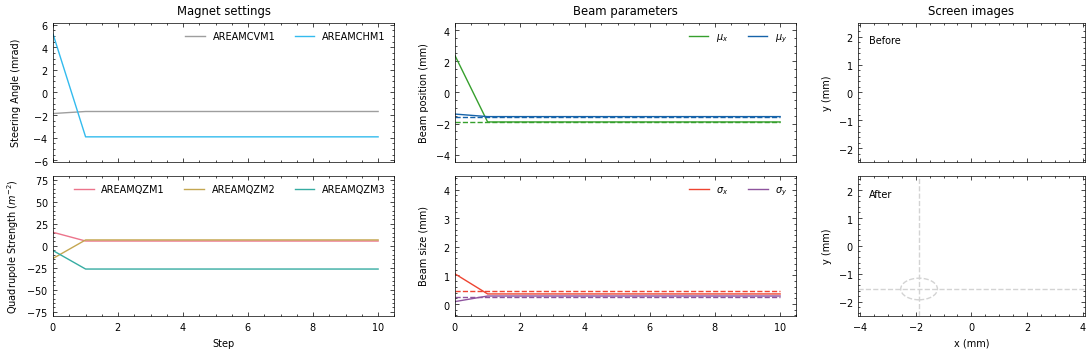

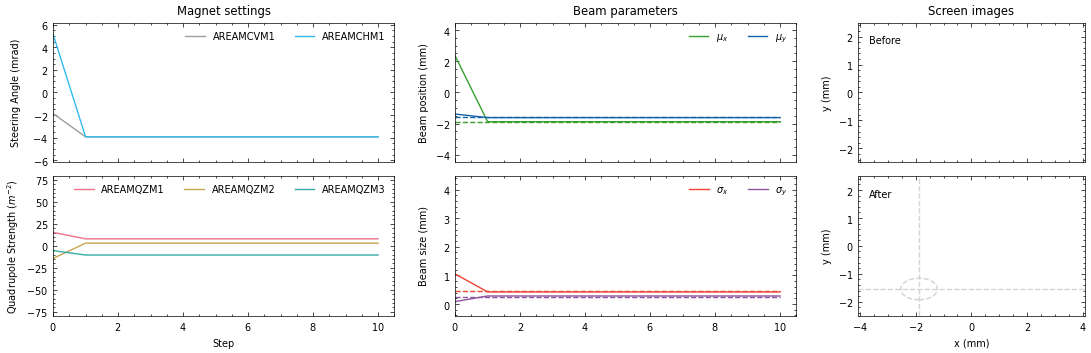

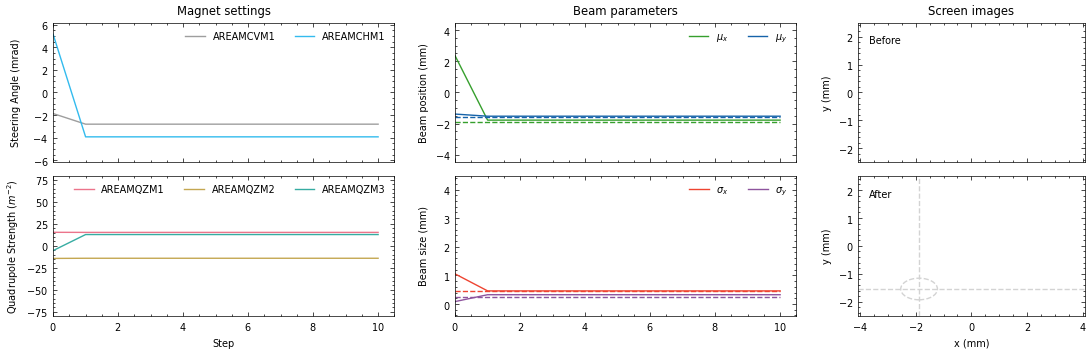

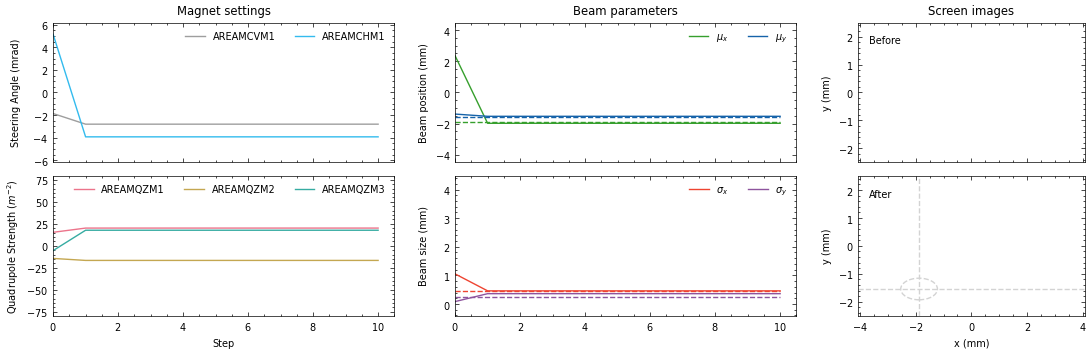

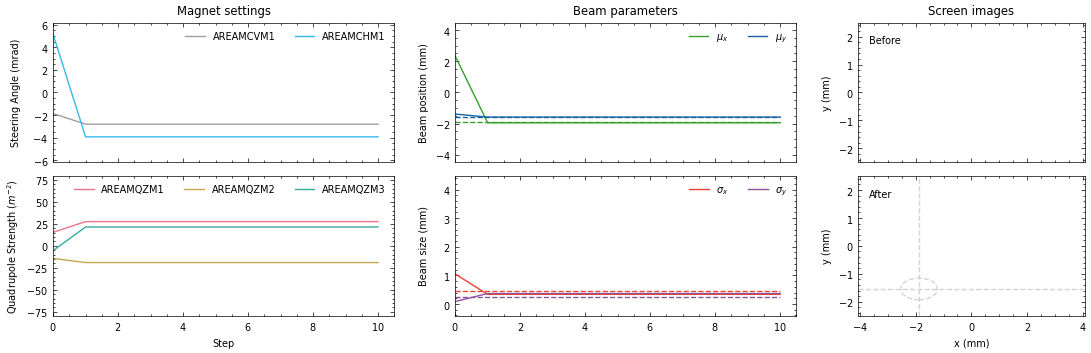

In [5]:
test_env = ea.TransverseTuning(
    backend="cheetah",
    action_mode="direct",
    target_beam_mode=trial.target_beam,
    magnet_init_mode=trial.initial_magnets,
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": True,
    },
)
test_env = TimeLimit(test_env, 10)
test_env = PlotEpisode(test_env, save_dir="../plots", episode_trigger=lambda _: True)

for result in results:
    _, _ = test_env.reset()
    done = False
    while not done:
        # result[2] is the action element of the tuple
        _, _, terminated, truncated, _ = test_env.step(result[2])
        done = terminated or truncated


test_env.close()

/opt/homebrew/Caskroom/miniforge/base/envs/ares-transverse-tuning/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:95: UserWarning: You loaded a model that was trained using OpenAI Gym. We strongly recommend transitioning to Gymnasium by saving that model again.
  warnings.warn(


Overwriting existing episode plots at /Users/jankaiser/Documents/DESY/ares-transverse-tuning/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
info['beam_reward'] = 0.930979200226038


/Users/jankaiser/Documents/DESY/ares-transverse-tuning/notebooks/../src/wrappers/plot_episode.py:123: UserWarning: WARN: Unable to save episode plot for self.episode_id = 1 because the episode was too short.
  logger.warn(


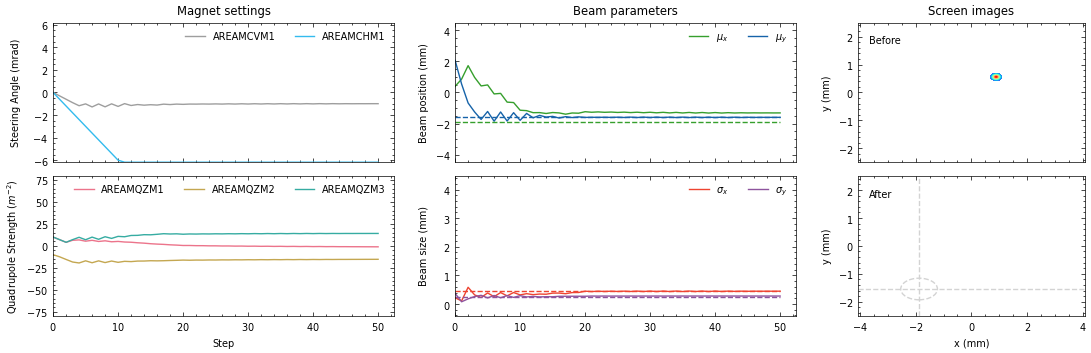

In [31]:
model = TD3.load(f"../models/ea/legacy/polished-donkey-996/model")

test_env = ea.TransverseTuning(
    backend="cheetah",
    action_mode="delta",
    max_quad_delta=30 * 0.1,
    max_steerer_delta=6e-3 * 0.1,
    target_beam_mode=trial.target_beam,
    magnet_init_mode=np.array([10, -10, 0, 10, 0]),
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": True,
    },
)
test_env = TimeLimit(test_env, 50)
test_env = PlotEpisode(test_env, save_dir="../plots", episode_trigger=lambda _: True)
test_env = RecordEpisode(test_env)
test_env = FlattenObservation(test_env)
test_env = PolishedDonkeyCompatibility(test_env)
test_env = NotVecNormalize(
    test_env, f"../models/ea/legacy/polished-donkey-996/vec_normalize.pkl"
)
test_env = RescaleAction(test_env, -1, 1)

observation, _ = test_env.reset()
done = False
while not done:
    action, _ = model.predict(observation, deterministic=True)
    observation, _, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

_, _ = test_env.reset()
record_episode = unwrap_wrapper(test_env, RecordEpisode)
last_beam_donkey = record_episode.previous_observations[-1]["beam"]


print(f"{info['beam_reward'] = }")
donkey_reward = info["beam_reward"]

test_env.close()


Overwriting existing episode plots at /Users/jankaiser/Documents/DESY/ares-transverse-tuning/plots folder. Specify a different `save_dir` for the `RecordEpisode` wrapper if this is not desired.
info['beam_reward'] = 0.9327039790999174


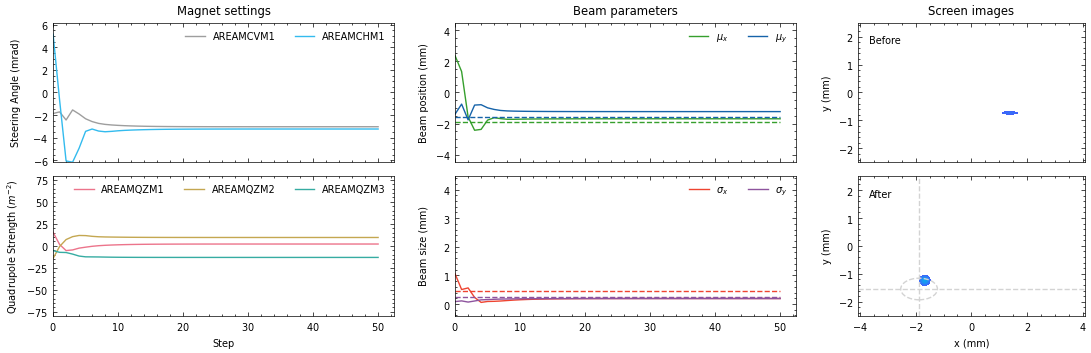

In [32]:
model = PPO.load(f"../models/colorful-sponge-28/model")

test_env = ea.TransverseTuning(
    backend="cheetah",
    action_mode="delta",
    max_quad_delta=72,
    max_steerer_delta=6.1782e-3,
    target_beam_mode=trial.target_beam,
    magnet_init_mode=trial.initial_magnets,
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
        "generate_screen_images": True,
    },
)
test_env = TimeLimit(test_env, 50)
test_env = PlotEpisode(test_env, save_dir="../plots", episode_trigger=lambda _: True)
test_env = RecordEpisode(test_env)
test_env = RescaleObservation(test_env, -1, 1)
test_env = RescaleAction(test_env, -1, 1)
test_env = FlattenObservation(test_env)

observation, _ = test_env.reset()
done = False
while not done:
    action, _ = model.predict(observation, deterministic=True)
    observation, _, terminated, truncated, info = test_env.step(action)
    done = terminated or truncated

_, _ = test_env.reset()
record_episode = unwrap_wrapper(test_env, RecordEpisode)
last_beam_sponge = record_episode.previous_observations[-1]["beam"]

print(f"{info['beam_reward'] = }")
sponge_reward = info["beam_reward"]

test_env.close()


In [33]:
grid_mae = np.mean(np.abs(results[3][0] - trial.target_beam))
donkey_mae = np.mean(np.abs(last_beam_donkey - trial.target_beam))
sponge_mae = np.mean(np.abs(last_beam_sponge - trial.target_beam))

print("MAEs")
print("----------------")
print(f"Grid search: {grid_mae}")
print(f"Donkey:      {donkey_mae}")
print(f"Sponge:      {sponge_mae}")


MAEs
----------------
Grid search: 2.223402407253161e-05
Donkey:      0.00016104620590340346
Sponge:      0.00020535859584924765


In [34]:
print("MAEs factor worse than grid search")
print("----------------")
print(f"Donkey:      {donkey_mae / grid_mae}")
print(f"Sponge:      {sponge_mae / grid_mae}")


MAEs factor worse than grid search
----------------
Donkey:      7.243232506092471
Sponge:      9.236231605188916


In [35]:
grid_reward = results[3][1]

print("Rewards")
print("----------------")
print(f"Grid search: {grid_reward}")
print(f"Donkey:      {donkey_reward}")
print(f"Sponge:      {sponge_reward}")

Rewards
----------------
Grid search: 0.9483831612642887
Donkey:      0.930979200226038
Sponge:      0.9327039790999174


In [36]:
print("Reward factors relative to grid search")
print("----------------")
print(f"Donkey:      {donkey_reward / grid_reward}")
print(f"Sponge:      {sponge_reward / grid_reward}")

Reward factors relative to grid search
----------------
Donkey:      0.9816488084678249
Sponge:      0.983467460405487
